# Import unwrap

In [1]:
import sys
!{sys.executable} -m pip uninstall -y unwrap
!{sys.executable} -m pip install --no-deps -U --no-cache git+https://github.com/jgraving/unwrap
!{sys.executable} -m pip install seaborn

Found existing installation: unwrap 0.0.1
Uninstalling unwrap-0.0.1:
  Successfully uninstalled unwrap-0.0.1
  Cloning https://github.com/jgraving/unwrap to /private/var/folders/nq/smdrxv810_z_tfcmgmg5gkb00000gn/T/pip-req-build-d9_v5_v6
  Running command git clone --filter=blob:none --quiet https://github.com/jgraving/unwrap /private/var/folders/nq/smdrxv810_z_tfcmgmg5gkb00000gn/T/pip-req-build-d9_v5_v6
  Resolved https://github.com/jgraving/unwrap to commit 8b62545d597cb49a7e7813433038603747a686e8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unwrap: filename=unwrap-0.0.1-py3-none-any.whl size=13504 sha256=f0df969f3a0257c7b305f0aec11b03a30db81bc9d75689deb4086533e9790c85
  Stored in directory: /private/var/folders/nq/smdrxv810_z_tfcmgmg5gkb00000gn/T/pip-ephem-wheel-cache-ndpo8llf/wheels/47/bc/53/d9d6125a8e23f45962719159f75463c156228288997ba3313f
Successfully built unwrap

[notic

# Read in data

In [2]:
import pandas as pd
import numpy as np
from unwrap.link.numpy import shifted_modulo

# Load the file
file_path = 'datasets/SecurityLightBergsig.txt'
df = pd.read_csv(file_path, sep='\t')

# Create a binary indicator for the Light (1 for 'ON', 0 for 'OFF')
df['Light'] = df['Experiment'].apply(lambda x: 1 if 'ON' in x else 0)

# Convert the 'Heading' column from degrees to radians
df['Heading'] = pd.to_numeric(df['Heading'], errors='coerce')  # Convert non-numeric values (e.g., 'NA') to NaN
df['HeadingRadians'] = np.deg2rad(df['Heading'])

# Normalize the heading radians to be between -pi and pi
df['HeadingRadians'] = df['HeadingRadians'].apply(lambda x: shifted_modulo(x) if pd.notnull(x) else x)

# Keep only the relevant columns and drop rows with missing values
df = df[['Light', 'Beetle', 'Trial', 'HeadingRadians']].dropna().copy()
df.reset_index(drop=True, inplace=True)

# Rename columns: change 'Beetle' to 'Individual'
df = df.rename(columns={'Beetle': 'Individual'})
df['Individual'] = df['Individual'].astype('category')

df.head()


Light Individual  Trial  HeadingRadians
0      1          1      1        2.617994
1      1          1      2       -2.792527
2      1          1      3       -2.792527
3      1          1      4       -2.617994
4      1          1      5       -2.617994

# Plot data

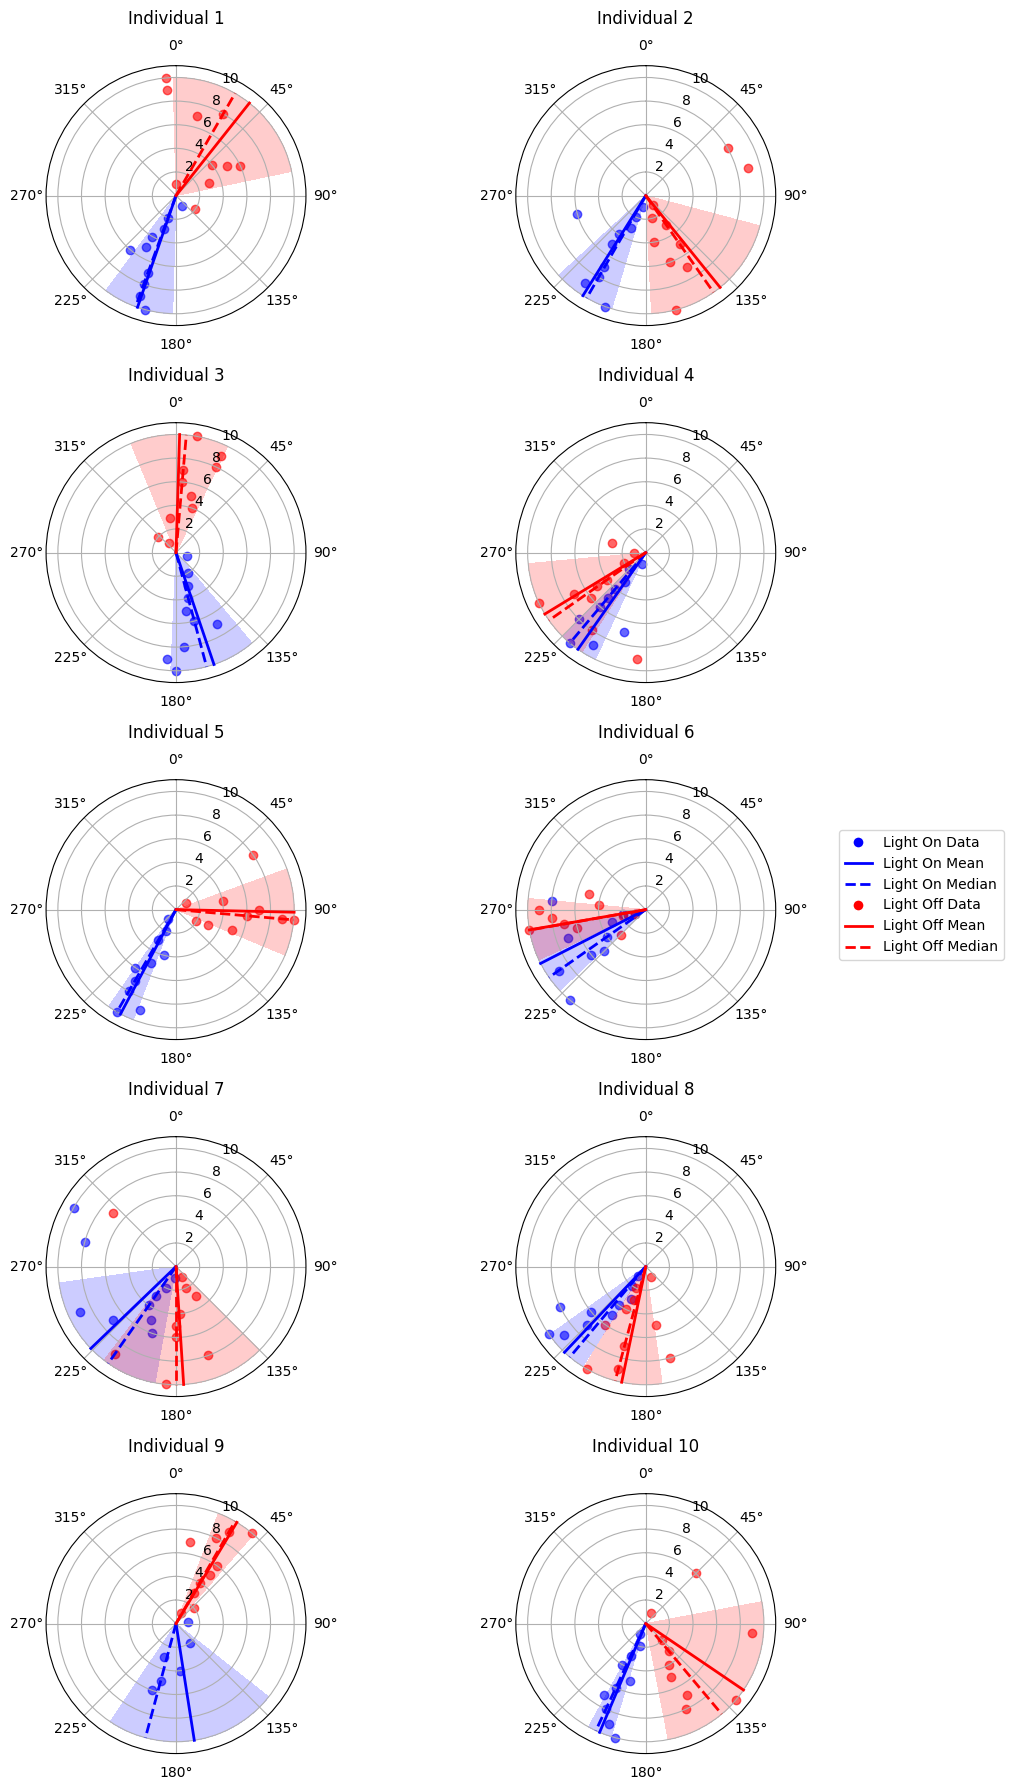

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import circmean, circstd
from matplotlib.lines import Line2D

# Helper function to compute the circular median.
def circ_median(angles):
    angles = np.sort(angles)
    diffs = np.abs(np.angle(np.exp(1j * (angles[:, None] - angles[None, :]))))
    sum_diffs = np.sum(diffs, axis=1)
    return angles[np.argmin(sum_diffs)]

# Helper function to scatter-plot data for one condition.
def plot_scatter(ax, data, angle_col, radial_col, color, label):
    if not data.empty:
        ax.scatter(data[angle_col], data[radial_col],
                   color=color, alpha=0.6, label=label)

# Helper function to compute and plot summary statistics.
# It plots a solid vertical line at the circular mean and a dashed vertical line at the circular median,
# both in the specified color. It also fills the region ± the circular standard deviation.
def plot_summary_stats(ax, angles, radial_max, color):
    # Compute circular mean, median, and standard deviation.
    mean_val = circmean(angles, high=np.pi, low=-np.pi)
    median_val = circ_median(angles)
    std_val = circstd(angles, high=np.pi, low=-np.pi, normalize=True)
    
    # Plot mean (solid) and median (dashed).
    ax.plot([mean_val, mean_val], [0, radial_max], color=color, linewidth=2)
    ax.plot([median_val, median_val], [0, radial_max], color=color, linewidth=2, linestyle='--')
    
    # Fill the region between mean minus std and mean plus std.
    theta_vals = np.linspace(mean_val - std_val, mean_val + std_val, 100)
    r_vals = np.linspace(0, radial_max, 100)
    Theta, R = np.meshgrid(theta_vals, r_vals)
    ax.contourf(Theta, R, np.ones_like(Theta), alpha=0.2, colors=[color])
    
    return mean_val, median_val, std_val

# Get unique individual IDs.
unique_individuals = df['Individual'].unique()

# Create a grid of polar subplots.
n_plots = len(unique_individuals)
n_rows, n_cols = 5, 2  # Adjust grid dimensions as needed.
fig, axes = plt.subplots(n_rows, n_cols, subplot_kw={'projection': 'polar'}, figsize=(10, 18))
axes = axes.flatten()

radial_max = 10  # Maximum radial value

# Plot for each individual.
for idx, individual in enumerate(unique_individuals):
    ax = axes[idx]
    individual_data = df[df['Individual'] == individual]

    ax.set_theta_zero_location('N')#place 0° at the top
    ax.set_theta_direction(-1)#reverse to clockwise
    
    # Separate Light On and Light Off data (drop NaNs in HeadingRadians).
    data_on = individual_data[individual_data['Light'] == 1].dropna(subset=['HeadingRadians'])
    data_off = individual_data[individual_data['Light'] == 0].dropna(subset=['HeadingRadians'])
    
    # Scatter-plot data.
    plot_scatter(ax, data_on, 'HeadingRadians', 'Trial', 'blue', 'Light On')
    plot_scatter(ax, data_off, 'HeadingRadians', 'Trial', 'red', 'Light Off')
    
    # Plot summary statistics for each condition.
    if not data_on.empty:
        plot_summary_stats(ax, data_on['HeadingRadians'].values, radial_max, 'blue')
    if not data_off.empty:
        plot_summary_stats(ax, data_off['HeadingRadians'].values, radial_max, 'red')
    
    ax.set_title(f'Individual {individual}', pad=30)
    ax.set_ylim(0, radial_max + 1)
    # Remove individual legends from each subplot.
    ax.legend().set_visible(False)

# Create a shared custom legend.
legend_handles = [
    # For Light On (blue)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Light On Data'),
    Line2D([0], [0], color='blue', lw=2, label='Light On Mean'),
    Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Light On Median'),
    # For Light Off (red)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Light Off Data'),
    Line2D([0], [0], color='red', lw=2, label='Light Off Mean'),
    Line2D([0], [0], color='red', lw=2, linestyle='--', label='Light Off Median'),
]

# Add one shared legend to the right of the figure.
fig.legend(handles=legend_handles, loc='center right', bbox_to_anchor=(1.10, 0.5), fontsize='medium')

plt.tight_layout()
plt.show()


# Model with a treatment effect on hyperparameters


In [4]:
# from fastprogress import fastprogress
# fastprogress.printing = lambda: True

import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula_treat = bmb.Formula(
    "HeadingRadians ~ Light + (1 + Light|Individual)",
    "kappa ~ Light + (1 + Light|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors_treat= {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    "Light": bmb.Prior("VonMises", mu=0, kappa= 1.0),#von Mises
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(30), sigma=0.6) # high shrinkage prior
    ),
    "Light|Individual": bmb.Prior(
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(30), sigma=0.6) # potential for large changes 
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(3), sigma=1.5),#wider possible range
        "Light": bmb.Prior("Normal", mu=0, sigma=1.5),#slightly wider
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.5)#slightly wider
        ),
        "Light|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.3)#slightly wider
        ),
    },
}

# Build the model using the updated formula and priors.
model_treat = bmb.Model(
    formula_treat,
    df,
    family="vonmises",
    priors=priors_treat,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model_treat)

# Fit the model.
idata_treat = model_treat.fit(tune = 1000, draws=1000,
                            # inference_method="nutpie",#faster
                            idata_kwargs={"log_likelihood": True},
                            sample_kwargs={
        "tune_kwargs": {
            "target_accept": 0.97  # Needs sampling with small steps
        }
    })


       Formula: HeadingRadians ~ Light + (1 + Light|Individual)
                kappa ~ Light + (1 + Light|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 196
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            Light ~ VonMises(mu: 0.0, kappa: 1.0)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 3.4011973816621555, sigma: 0.6))
            Light|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 3.4011973816621555, sigma: 0.6))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 2.9489308190572983, sigma: 1.5)
            kappa_Light ~ Normal(mu: 0.0, sigma: 1.5)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931471805599453, sigma: 0.5))
            kappa_Light|Individual ~ Normal(mu: 0.0, sigma

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Light, 1|Individual_kappa, 1|Individual, Light|Individual_kappa, Light|Individual, kappa_Intercept, kappa_Light, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_Light|Individual_sigma, kappa_Light|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.


## Inspect summary


In [5]:
az.summary(
    idata_treat, 
    var_names=["Intercept", "Light", "kappa_Intercept", "kappa_Light", "1|Individual_kappa", "Light|Individual_kappa",
                "kappa_1|Individual_sigma", "kappa_Light|Individual_sigma"],
    circ_var_names=["Intercept", "Light"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                     2.260  0.512   1.364   -2.955      0.011   
Light                         1.312  0.280   0.770    1.841      0.014   
kappa_Intercept               4.267  0.587   3.177    5.353      0.010   
kappa_Light                   2.609  0.912   0.805    4.170      0.014   
1|Individual_kappa            1.837  0.458   0.995    2.675      0.007   
Light|Individual_kappa        2.756  0.748   1.445    4.158      0.011   
kappa_1|Individual_sigma      0.784  0.413   0.169    1.552      0.008   
kappa_Light|Individual_sigma  0.567  0.185   0.263    0.923      0.003   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                       0.080     994.0     691.0   1.00  
Light                           0.006     865.0    1316.0   1.01  
kappa_Intercept                 0.010    3563.0    2439.0   1.00  
kappa_Light                     0.014    4445.0    2887.0   1.00  
1|Individual_kappa              0.008    4262.0    2801.0   1.00  
Light|Individual_kappa          0.013    4656.0    2807.0   1.00  
kappa_1|Individual_sigma        0.007    2700.0    3184.0   1.00  
kappa_Light|Individual_sigma    0.004    4098.0    2600.0   1.00

In [6]:
az.summary(
    idata_treat, 
    var_names=["1|Individual", "Light|Individual",
                "kappa_1|Individual", "kappa_Light|Individual"],
    circ_var_names=["1|Individual", "Light|Individual"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
1|Individual[1]            -1.446  0.546  -2.522   -0.455      0.010    0.031   
1|Individual[2]             0.188  0.516  -0.777    1.191      0.011    0.017   
1|Individual[3]            -2.124  0.547   3.052   -1.146      0.013    0.077   
1|Individual[4]             1.798  0.537   0.780    2.801      0.012    0.048   
1|Individual[5]            -0.607  0.520  -1.616    0.350      0.011    0.018   
1|Individual[6]             2.190  0.543   1.124   -3.090      0.012    0.063   
1|Individual[7]             0.739  0.523  -0.332    1.662      0.010    0.017   
1|Individual[8]             1.020  0.522   0.091    2.081      0.011    0.017   
1|Individual[9]            -1.623  0.536  -2.598   -0.557      0.011    0.048   
1|Individual[10]           -0.085  0.519  -1.022    0.965      0.011    0.016   
Light|Individual[1]         1.305  0.355   0.630    1.970      0.014    0.006   
Light|Individual[2]        -0.056  0.316  -0.675    0.513      0.014    0.005   
Light|Individual[3]         1.329  0.345   0.673    2.002      0.014    0.006   
Light|Individual[4]        -1.583  0.343  -2.233   -0.942      0.014    0.005   
Light|Individual[5]         0.644  0.322   0.037    1.261      0.013    0.005   
Light|Individual[6]        -1.488  0.336  -2.155   -0.870      0.014    0.006   
Light|Individual[7]        -0.346  0.330  -0.982    0.252      0.013    0.005   
Light|Individual[8]        -0.669  0.317  -1.228   -0.020      0.013    0.005   
Light|Individual[9]         0.966  0.349   0.304    1.598      0.014    0.006   
Light|Individual[10]        0.051  0.326  -0.561    0.666      0.013    0.005   
kappa_1|Individual[1]      -0.367  0.763  -1.890    1.077      0.012    0.014   
kappa_1|Individual[2]      -0.114  0.740  -1.601    1.288      0.011    0.015   
kappa_1|Individual[3]       0.151  0.753  -1.163    1.738      0.011    0.014   
kappa_1|Individual[4]       0.344  0.788  -1.167    1.848      0.013    0.016   
kappa_1|Individual[5]       0.605  0.932  -0.895    2.526      0.016    0.024   
kappa_1|Individual[6]       0.582  0.936  -0.826    2.584      0.015    0.020   
kappa_1|Individual[7]      -0.913  0.861  -2.722    0.368      0.016    0.014   
kappa_1|Individual[8]       0.581  0.879  -0.883    2.301      0.015    0.021   
kappa_1|Individual[9]      -0.018  0.723  -1.523    1.272      0.010    0.013   
kappa_1|Individual[10]     -0.369  0.754  -1.879    0.981      0.013    0.014   
kappa_Light|Individual[1]   0.103  0.597  -1.002    1.277      0.009    0.013   
kappa_Light|Individual[2]   0.136  0.584  -0.918    1.298      0.008    0.012   
kappa_Light|Individual[3]  -0.010  0.609  -1.199    1.146      0.009    0.013   
kappa_Light|Individual[4]   0.166  0.583  -0.912    1.268      0.009    0.011   
kappa_Light|Individual[5]   0.186  0.601  -0.938    1.329      0.009    0.011   
kappa_Light|Individual[6]   0.072  0.565  -0.983    1.171      0.008    0.010   
kappa_Light|Individual[7]  -0.309  0.598  -1.468    0.814      0.008    0.011   
kappa_Light|Individual[8]   0.163  0.595  -1.032    1.236      0.009    0.011   
kappa_Light|Individual[9]  -0.363  0.622  -1.593    0.775      0.010    0.012   
kappa_Light|Individual[10]  0.225  0.607  -0.898    1.354      0.010    0.012   

                            ess_bulk  ess_tail  r_hat  
1|Individual[1]                633.0     817.0   1.00  
1|Individual[2]                533.0     805.0   1.00  
1|Individual[3]               1029.0     769.0   1.00  
1|Individual[4]                599.0     843.0   1.00  
1|Individual[5]                517.0     677.0   1.00  
1|Individual[6]                779.0    1113.0   1.00  
1|Individual[7]                535.0     773.0   1.00  
1|Individual[8]                516.0     689.0   1.00  
1|Individual[9]                700.0    1004.0   1.00  
1|Individual[10]               519.0     764.0   1.00  
Light|Individual[1]           1271.0    1969.0   1.00  
Light|Individual[2]           1179.

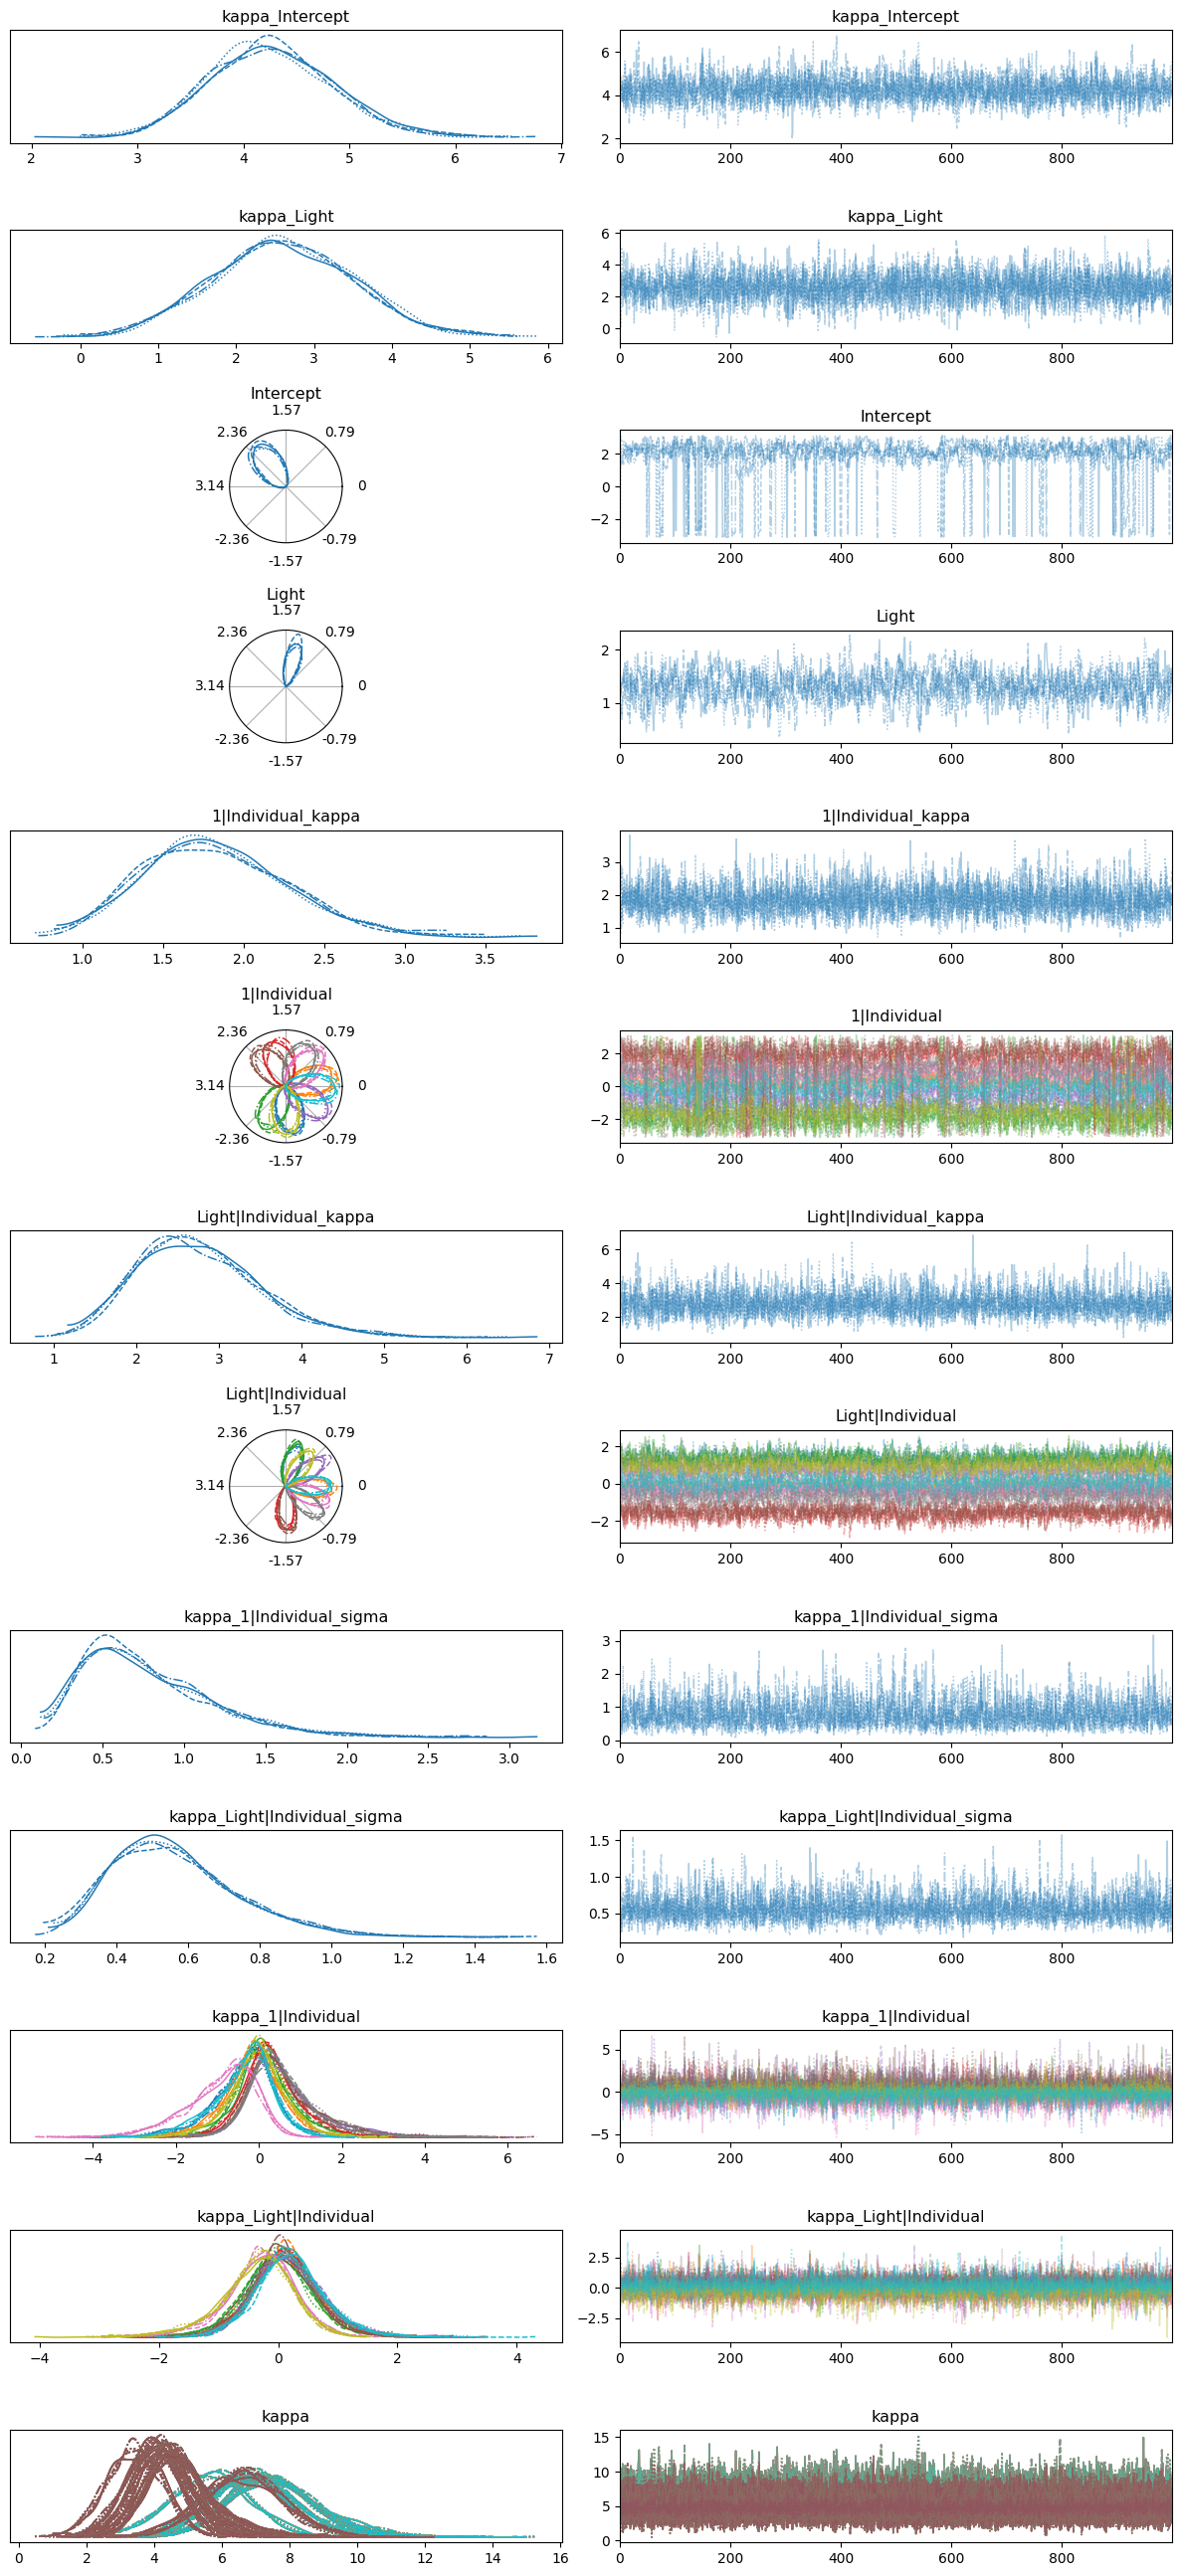

In [7]:
# varnms = ["Intercept", "Light", "kappa_Intercept", "kappa_Light"],
#Specify which parameters are circular
cvars = ["Intercept", "Light", "1|Individual", "Light|Individual"]
#transform the circular data for interpretability
idata_treat_trans = idata_treat.copy() # set up a variable for transformed data
# for cvar in cvars:
#     idata_treat_trans.posterior[cvar] = -180*idata_treat_trans.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(idata_treat,
            #   var_names=varnms,
              circ_var_names=cvars,
              #circ_var_units='degrees'
              ) #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

We can already see here that the mode of Light|Individual $\kappa$ is slightly higher then for 1|Individual $\kappa$ and the $\log(\exp(x)+1)$ transform, this would correspond to an increase in $\kappa$ of $\approx -0.58—2.43$.  Note that this effect is separate from the effect of the light on individual accuracy ("$\kappa$ Light"), which was also large and overwhelmingly positive, but needn't necessarily imply greater alignment between individuals.

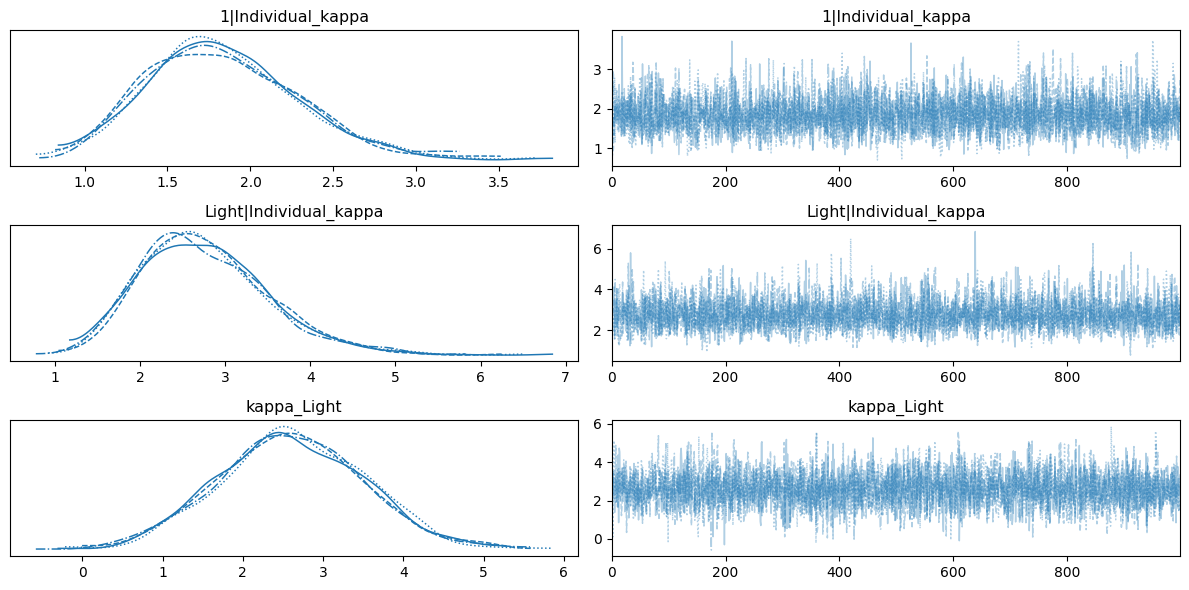

In [8]:
az.plot_trace(idata_treat,
              var_names=["1|Individual_kappa","Light|Individual_kappa", "kappa_Light"],
              )
plt.tight_layout()
plt.show()

In [9]:
#TODO delete not helpful
# Import softplus from unwrap.link.numpy
from unwrap.link.numpy import softplus
# For the κ_μ-model:
kappamu_intercept = idata_treat.posterior["1|Individual_kappa"].values    # fixed intercept for κ_μ (linear predictor)
kappamu_slope     = idata_treat.posterior["Light|Individual_kappa"].values        # fixed slope for κ_μ (linear predictor)
kappamu_pop_off_samples_all = softplus(kappamu_intercept.flatten())
kappamu_pop_on_samples_all  = softplus(kappamu_slope.flatten())
#How large is the effect of the light on kappa_mu?
np.quantile(kappamu_pop_on_samples_all - kappamu_pop_off_samples_all, q = [0.025, 0.975])

array([-0.54125668,  2.52423286])

# Model no change in $\kappa_\mu$
Our hypothesis is that turning on the light increased the correlation across individual headings. We could test this by excluding the effect of light on the population of individual headings.

In [10]:
# from fastprogress import fastprogress
# fastprogress.printing = lambda: True

import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula_nolight_km = bmb.Formula(
    "HeadingRadians ~ Light + (1|Individual)",
    "kappa ~ Light + (1 + Light|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors_nolight_km= {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    "Light": bmb.Prior("VonMises", mu=0, kappa= 1.0),#For this model this parameter is now difficult to estimate (as we would expect)
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(15), sigma=0.3)#needs to be low to converge
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(1.0), sigma=3.0),#combined expected to be lower
        "Light": bmb.Prior("Normal", mu=0, sigma=3.0),#narrower
        # Individual-level effects for κ:
         "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.5)#slightly wider
        ),
        "Light|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.3)#slightly wider
        ),
    },
}

# Build the model using the updated formula and priors.
model_nolight_km = bmb.Model(
    formula_nolight_km,
    df,
    family="vonmises",
    priors=priors_nolight_km,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model_nolight_km)

# Fit the model.
idata_nolight_km = model_nolight_km.fit(tune = 1000, draws=1000,
                            idata_kwargs={"log_likelihood": True},
                            sample_kwargs={
        "tune_kwargs": {
            "target_accept": 0.99  # take small steps to avoid divergences
        }
    })


       Formula: HeadingRadians ~ Light + (1|Individual)
                kappa ~ Light + (1 + Light|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 196
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            Light ~ VonMises(mu: 0.0, kappa: 1.0)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 2.70805020110221, sigma: 0.3))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 0.5413248546129181, sigma: 3.0)
            kappa_Light ~ Normal(mu: 0.0, sigma: 3.0)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931471805599453, sigma: 0.5))
            kappa_Light|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931471805599453, sigma: 0.3))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Light, 1|Individual_kappa, 1|Individual, kappa_Intercept, kappa_Light, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_Light|Individual_sigma, kappa_Light|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


# Inspect summary

In [11]:
az.summary(
    idata_nolight_km, 
    var_names=["Intercept", "Light", "kappa_Intercept", "kappa_Light", "1|Individual_kappa",
                "kappa_1|Individual_sigma"],
    circ_var_names=["Intercept", "Light"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                  2.306  0.615   1.213   -2.896      0.027    0.081   
Light                      1.306  0.596   0.161    2.276      0.027    0.013   
kappa_Intercept            0.377  0.750  -1.136    1.711      0.022    0.017   
kappa_Light                7.308  1.252   4.997    9.675      0.031    0.027   
1|Individual_kappa        10.975  2.814   6.090   16.174      0.051    0.054   
kappa_1|Individual_sigma   1.667  0.653   0.552    2.857      0.021    0.018   

                          ess_bulk  ess_tail  r_hat  
Intercept                   1104.0    1559.0   1.00  
Light                        270.0     773.0   1.01  
kappa_Intercept             1236.0    1363.0   1.00  
kappa_Light                 1779.0    1419.0   1.00  
1|Individual_kappa          3213.0    2724.0   1.00  
kappa_1|Individual_sigma    1059.0    1323.0   1.00

In [12]:
az.summary(
    idata_treat, 
    var_names=["1|Individual", "Light|Individual",
                "kappa_1|Individual"],
    circ_var_names=["1|Individual", "Light|Individual"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
1|Individual[1]        -1.446  0.546  -2.522   -0.455      0.010    0.031   
1|Individual[2]         0.188  0.516  -0.777    1.191      0.011    0.017   
1|Individual[3]        -2.124  0.547   3.052   -1.146      0.013    0.077   
1|Individual[4]         1.798  0.537   0.780    2.801      0.012    0.048   
1|Individual[5]        -0.607  0.520  -1.616    0.350      0.011    0.018   
1|Individual[6]         2.190  0.543   1.124   -3.090      0.012    0.063   
1|Individual[7]         0.739  0.523  -0.332    1.662      0.010    0.017   
1|Individual[8]         1.020  0.522   0.091    2.081      0.011    0.017   
1|Individual[9]        -1.623  0.536  -2.598   -0.557      0.011    0.048   
1|Individual[10]       -0.085  0.519  -1.022    0.965      0.011    0.016   
Light|Individual[1]     1.305  0.355   0.630    1.970      0.014    0.006   
Light|Individual[2]    -0.056  0.316  -0.675    0.513      0.014    0.005   
Light|Individual[3]     1.329  0.345   0.673    2.002      0.014    0.006   
Light|Individual[4]    -1.583  0.343  -2.233   -0.942      0.014    0.005   
Light|Individual[5]     0.644  0.322   0.037    1.261      0.013    0.005   
Light|Individual[6]    -1.488  0.336  -2.155   -0.870      0.014    0.006   
Light|Individual[7]    -0.346  0.330  -0.982    0.252      0.013    0.005   
Light|Individual[8]    -0.669  0.317  -1.228   -0.020      0.013    0.005   
Light|Individual[9]     0.966  0.349   0.304    1.598      0.014    0.006   
Light|Individual[10]    0.051  0.326  -0.561    0.666      0.013    0.005   
kappa_1|Individual[1]  -0.367  0.763  -1.890    1.077      0.012    0.014   
kappa_1|Individual[2]  -0.114  0.740  -1.601    1.288      0.011    0.015   
kappa_1|Individual[3]   0.151  0.753  -1.163    1.738      0.011    0.014   
kappa_1|Individual[4]   0.344  0.788  -1.167    1.848      0.013    0.016   
kappa_1|Individual[5]   0.605  0.932  -0.895    2.526      0.016    0.024   
kappa_1|Individual[6]   0.582  0.936  -0.826    2.584      0.015    0.020   
kappa_1|Individual[7]  -0.913  0.861  -2.722    0.368      0.016    0.014   
kappa_1|Individual[8]   0.581  0.879  -0.883    2.301      0.015    0.021   
kappa_1|Individual[9]  -0.018  0.723  -1.523    1.272      0.010    0.013   
kappa_1|Individual[10] -0.369  0.754  -1.879    0.981      0.013    0.014   

                        ess_bulk  ess_tail  r_hat  
1|Individual[1]            633.0     817.0   1.00  
1|Individual[2]            533.0     805.0   1.00  
1|Individual[3]           1029.0     769.0   1.00  
1|Individual[4]            599.0     843.0   1.00  
1|Individual[5]            517.0     677.0   1.00  
1|Individual[6]            779.0    1113.0   1.00  
1|Individual[7]            535.0     773.0   1.00  
1|Individual[8]            516.0     689.0   1.00  
1|Individual[9]            700.0    1004.0   1.00  
1|Individual[10]           519.0     764.0   1.00  
Light|Individual[1]       1271.0    1969.0   1.00  
Light|Individual[2]       1179.0    1861.0   1.00  
Light|Individual[3]       1111.0    1917.0   1.01  
Light|Individual[4]       1145.0    1967.0   1.01  
Light|Individual[5]       1192.0    1765.0   1.01  
Light|Individual[6]       1094.0    1535.0   1.00  
Light|Individual[7]       1333.0    1881.0   1.00  
Light|Individual[8]       1094.0    1867.0   1.00  
Light|Individual[9]       1390.0    2206.0   1.00  
Light|Individual[10]      1280.0    1969.0   1.00  
kappa_1|Individual[1]     3942.0    3485.0   1.00  
kappa_1|Individual[2]     5040.0    2778.0   1.00  
kappa_1|Individual[3]     4481.0    3161.0   1.00  
kappa_1|Individual[4]     4131.0    3243.0   1.00  
kappa_1|Individual[5]     3788.0    3193.0   1.00  
kappa_1|Individual[6]     4313.0    3065.0   1.00  
kappa_1|Individual[7]     2890.0    3347.0   1.00  
kappa_1|Individual[8]     3755.0    2671.0   1.00  
kappa_1|Individual[9]     4964.0    3407.0   1.00  
kappa_1|Individual[10]    3626.0    3171.0   1.00

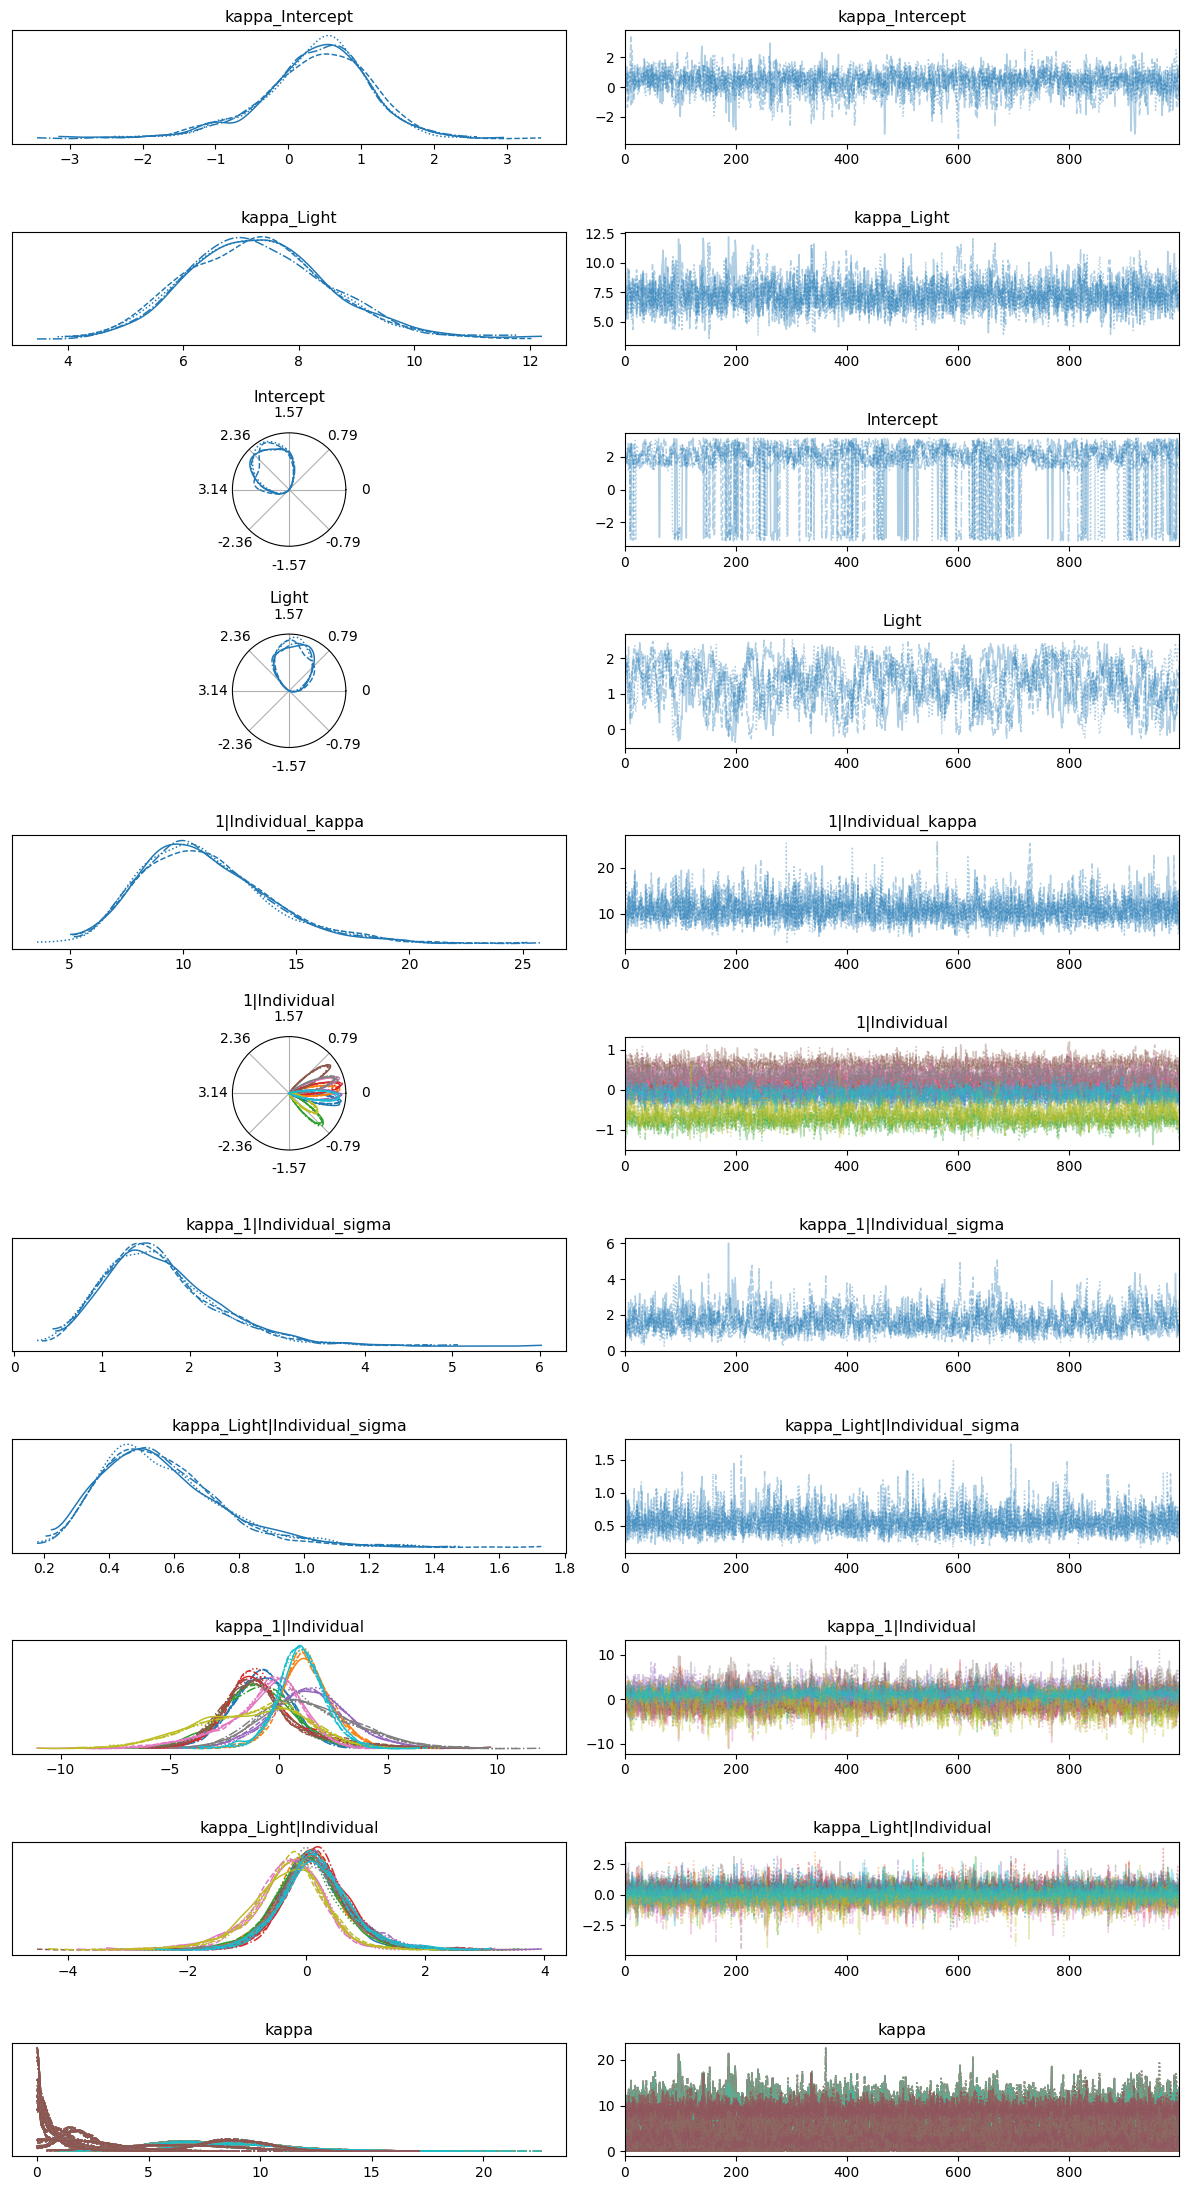

In [13]:
#Specify which parameters are circular
cvars = ["Intercept", "Light", "1|Individual", "Light|Individual"]

az.plot_trace(idata_nolight_km,
              circ_var_names=cvars,
              ) 
plt.tight_layout()
plt.show()

# Model for no population $\mu$
Under natural conditions, such as the control condition for this dataset, the heading biases of individuals of this species are often uncorrelated with one another. This can be modelled by removing the intercept parameter, and restricting the $\kappa_\mu$ hyperparameter to $\approx 0$ in the intercept (control) condition.

In [14]:
# from fastprogress import fastprogress
# fastprogress.printing = lambda: True

import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula_nomu = bmb.Formula(
    "HeadingRadians ~ 0 + Light + (1 + Light|Individual)",
    "kappa ~ Light + (1 + Light|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors_nomu= {
    # Fixed effects for μ:
    "Light": bmb.Prior("VonMises", mu=0, kappa= 1.0),#For this model this parameter is now difficult to estimate (as we would expect)
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(1e-16), sigma=0.1)#needs to be low to converge
    ),
    "Light|Individual": bmb.Prior(
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(30), sigma=0.6) # potential for large changes 
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(1.0), sigma=3.0),#combined expected to be lower
        "Light": bmb.Prior("Normal", mu=0, sigma=3.0),#narrower
        # Individual-level effects for κ:
         "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.5)#slightly wider
        ),
        "Light|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.3)#slightly wider
        ),
    },
}

# Build the model using the updated formula and priors.
model_nomu = bmb.Model(
    formula_nomu,
    df,
    family="vonmises",
    priors=priors_nomu,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model_nomu)

# Fit the model.
idata_nomu = model_nomu.fit(tune = 1000, draws=1000,
                            idata_kwargs={"log_likelihood": True},
                            sample_kwargs={
        "tune_kwargs": {
            "target_accept": 0.99  # take small steps to avoid divergences
        }
    })


       Formula: HeadingRadians ~ 0 + Light + (1 + Light|Individual)
                kappa ~ Light + (1 + Light|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 196
        Priors: 
    target = mu
        Common-level effects
            Light ~ VonMises(mu: 0.0, kappa: 1.0)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: -36.841361487904734, sigma: 0.1))
            Light|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 3.4011973816621555, sigma: 0.6))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 0.5413248546129181, sigma: 3.0)
            kappa_Light ~ Normal(mu: 0.0, sigma: 3.0)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931471805599453, sigma: 0.5))
            kappa_Light|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931471805599453, 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Light, 1|Individual_kappa, 1|Individual, Light|Individual_kappa, Light|Individual, kappa_Intercept, kappa_Light, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_Light|Individual_sigma, kappa_Light|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


## Inspect summary


In [15]:
az.summary(
    idata_nomu, 
    var_names=["Light", "kappa_Intercept", "kappa_Light", "1|Individual_kappa", "Light|Individual_kappa",
                "kappa_1|Individual_sigma", "kappa_Light|Individual_sigma"],
    circ_var_names=[ "Light"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Light                         1.297  0.293   0.738    1.827      0.006   
kappa_Intercept               4.202  0.628   3.087    5.455      0.009   
kappa_Light                   3.585  1.140   1.488    5.729      0.015   
1|Individual_kappa            0.000  0.000   0.000    0.000      0.000   
Light|Individual_kappa        2.615  0.709   1.366    3.943      0.009   
kappa_1|Individual_sigma      0.810  0.431   0.159    1.565      0.008   
kappa_Light|Individual_sigma  0.570  0.188   0.273    0.933      0.002   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Light                           0.006    1164.0    1446.0    1.0  
kappa_Intercept                 0.009    5259.0    3015.0    1.0  
kappa_Light                     0.019    5803.0    2734.0    1.0  
1|Individual_kappa              0.000    9807.0    3089.0    1.0  
Light|Individual_kappa          0.012    6158.0    3087.0    1.0  
kappa_1|Individual_sigma        0.007    3028.0    3053.0    1.0  
kappa_Light|Individual_sigma    0.004    8459.0    2894.0    1.0

In [16]:
az.summary(
    idata_nomu, 
    var_names=["1|Individual", "Light|Individual",
                "kappa_1|Individual"],
    circ_var_names=["1|Individual", "Light|Individual"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
1|Individual[1]         0.759  0.197   0.399    1.131      0.002    0.004   
1|Individual[2]         2.456  0.175   2.117    2.776      0.002    0.003   
1|Individual[3]         0.096  0.162  -0.208    0.395      0.001    0.003   
1|Individual[4]        -2.179  0.163  -2.482   -1.872      0.002    0.003   
1|Individual[5]         1.630  0.157   1.321    1.910      0.001    0.003   
1|Individual[6]        -1.798  0.148  -2.070   -1.516      0.001    0.003   
1|Individual[7]         3.043  0.201   2.658   -2.869      0.002    0.018   
1|Individual[8]        -2.977  0.151   3.024   -2.701      0.001    0.038   
1|Individual[9]         0.597  0.160   0.311    0.907      0.001    0.003   
1|Individual[10]        2.170  0.191   1.802    2.527      0.002    0.004   
Light|Individual[1]     1.380  0.370   0.737    2.100      0.006    0.006   
Light|Individual[2]    -0.051  0.330  -0.673    0.580      0.005    0.005   
Light|Individual[3]     1.390  0.354   0.715    2.051      0.005    0.006   
Light|Individual[4]    -1.622  0.355  -2.267   -0.929      0.006    0.006   
Light|Individual[5]     0.685  0.334   0.063    1.341      0.006    0.006   
Light|Individual[6]    -1.511  0.344  -2.164   -0.869      0.005    0.006   
Light|Individual[7]    -0.376  0.349  -1.026    0.296      0.009    0.006   
Light|Individual[8]    -0.682  0.329  -1.296   -0.068      0.006    0.005   
Light|Individual[9]     1.026  0.366   0.349    1.726      0.009    0.006   
Light|Individual[10]    0.075  0.341  -0.575    0.688      0.005    0.005   
kappa_1|Individual[1]  -0.402  0.770  -1.867    1.020      0.011    0.015   
kappa_1|Individual[2]  -0.164  0.740  -1.602    1.235      0.010    0.013   
kappa_1|Individual[3]   0.150  0.774  -1.321    1.656      0.010    0.016   
kappa_1|Individual[4]   0.384  0.829  -1.109    1.978      0.012    0.020   
kappa_1|Individual[5]   0.597  0.909  -0.843    2.518      0.013    0.019   
kappa_1|Individual[6]   0.589  0.905  -0.870    2.422      0.014    0.019   
kappa_1|Individual[7]  -0.983  0.917  -2.759    0.530      0.015    0.013   
kappa_1|Individual[8]   0.602  0.935  -0.764    2.553      0.013    0.018   
kappa_1|Individual[9]  -0.048  0.744  -1.515    1.425      0.010    0.015   
kappa_1|Individual[10] -0.420  0.757  -1.910    0.879      0.011    0.014   

                        ess_bulk  ess_tail  r_hat  
1|Individual[1]           6657.0    2758.0    1.0  
1|Individual[2]           8270.0    2703.0    1.0  
1|Individual[3]           7568.0    2301.0    1.0  
1|Individual[4]           8024.0    2924.0    1.0  
1|Individual[5]           7247.0    2382.0    1.0  
1|Individual[6]           8290.0    2838.0    1.0  
1|Individual[7]           2817.0    3686.0    1.0  
1|Individual[8]           2952.0    3844.0    1.0  
1|Individual[9]           9223.0    2520.0    1.0  
1|Individual[10]          7853.0    2969.0    1.0  
Light|Individual[1]       1532.0    2191.0    1.0  
Light|Individual[2]       1488.0    2126.0    1.0  
Light|Individual[3]       1521.0    2294.0    1.0  
Light|Individual[4]       1428.0    1896.0    1.0  
Light|Individual[5]       1481.0    2263.0    1.0  
Light|Individual[6]       1379.0    1856.0    1.0  
Light|Individual[7]       1800.0    2264.0    1.0  
Light|Individual[8]       1321.0    2139.0    1.0  
Light|Individual[9]       1659.0    1922.0    1.0  
Light|Individual[10]      1661.0    2289.0    1.0  
kappa_1|Individual[1]     5497.0    3062.0    1.0  
kappa_1|Individual[2]     6306.0    2999.0    1.0  
kappa_1|Individual[3]     7025.0    3291.0    1.0  
kappa_1|Individual[4]     5625.0    3268.0    1.0  
kappa_1|Individual[5]     5518.0    3338.0    1.0  
kappa_1|Individual[6]     5197.0    3322.0    1.0  
kappa_1|Individual[7]     3682.0    3005.0    1.0  
kappa_1|Individual[8]     5297.0    3472.0    1.0  
kappa_1|Individual[9]     5919.0    2913.0    1.0  
kappa_1|Individual[10]    5057.0    3399.0    1.0

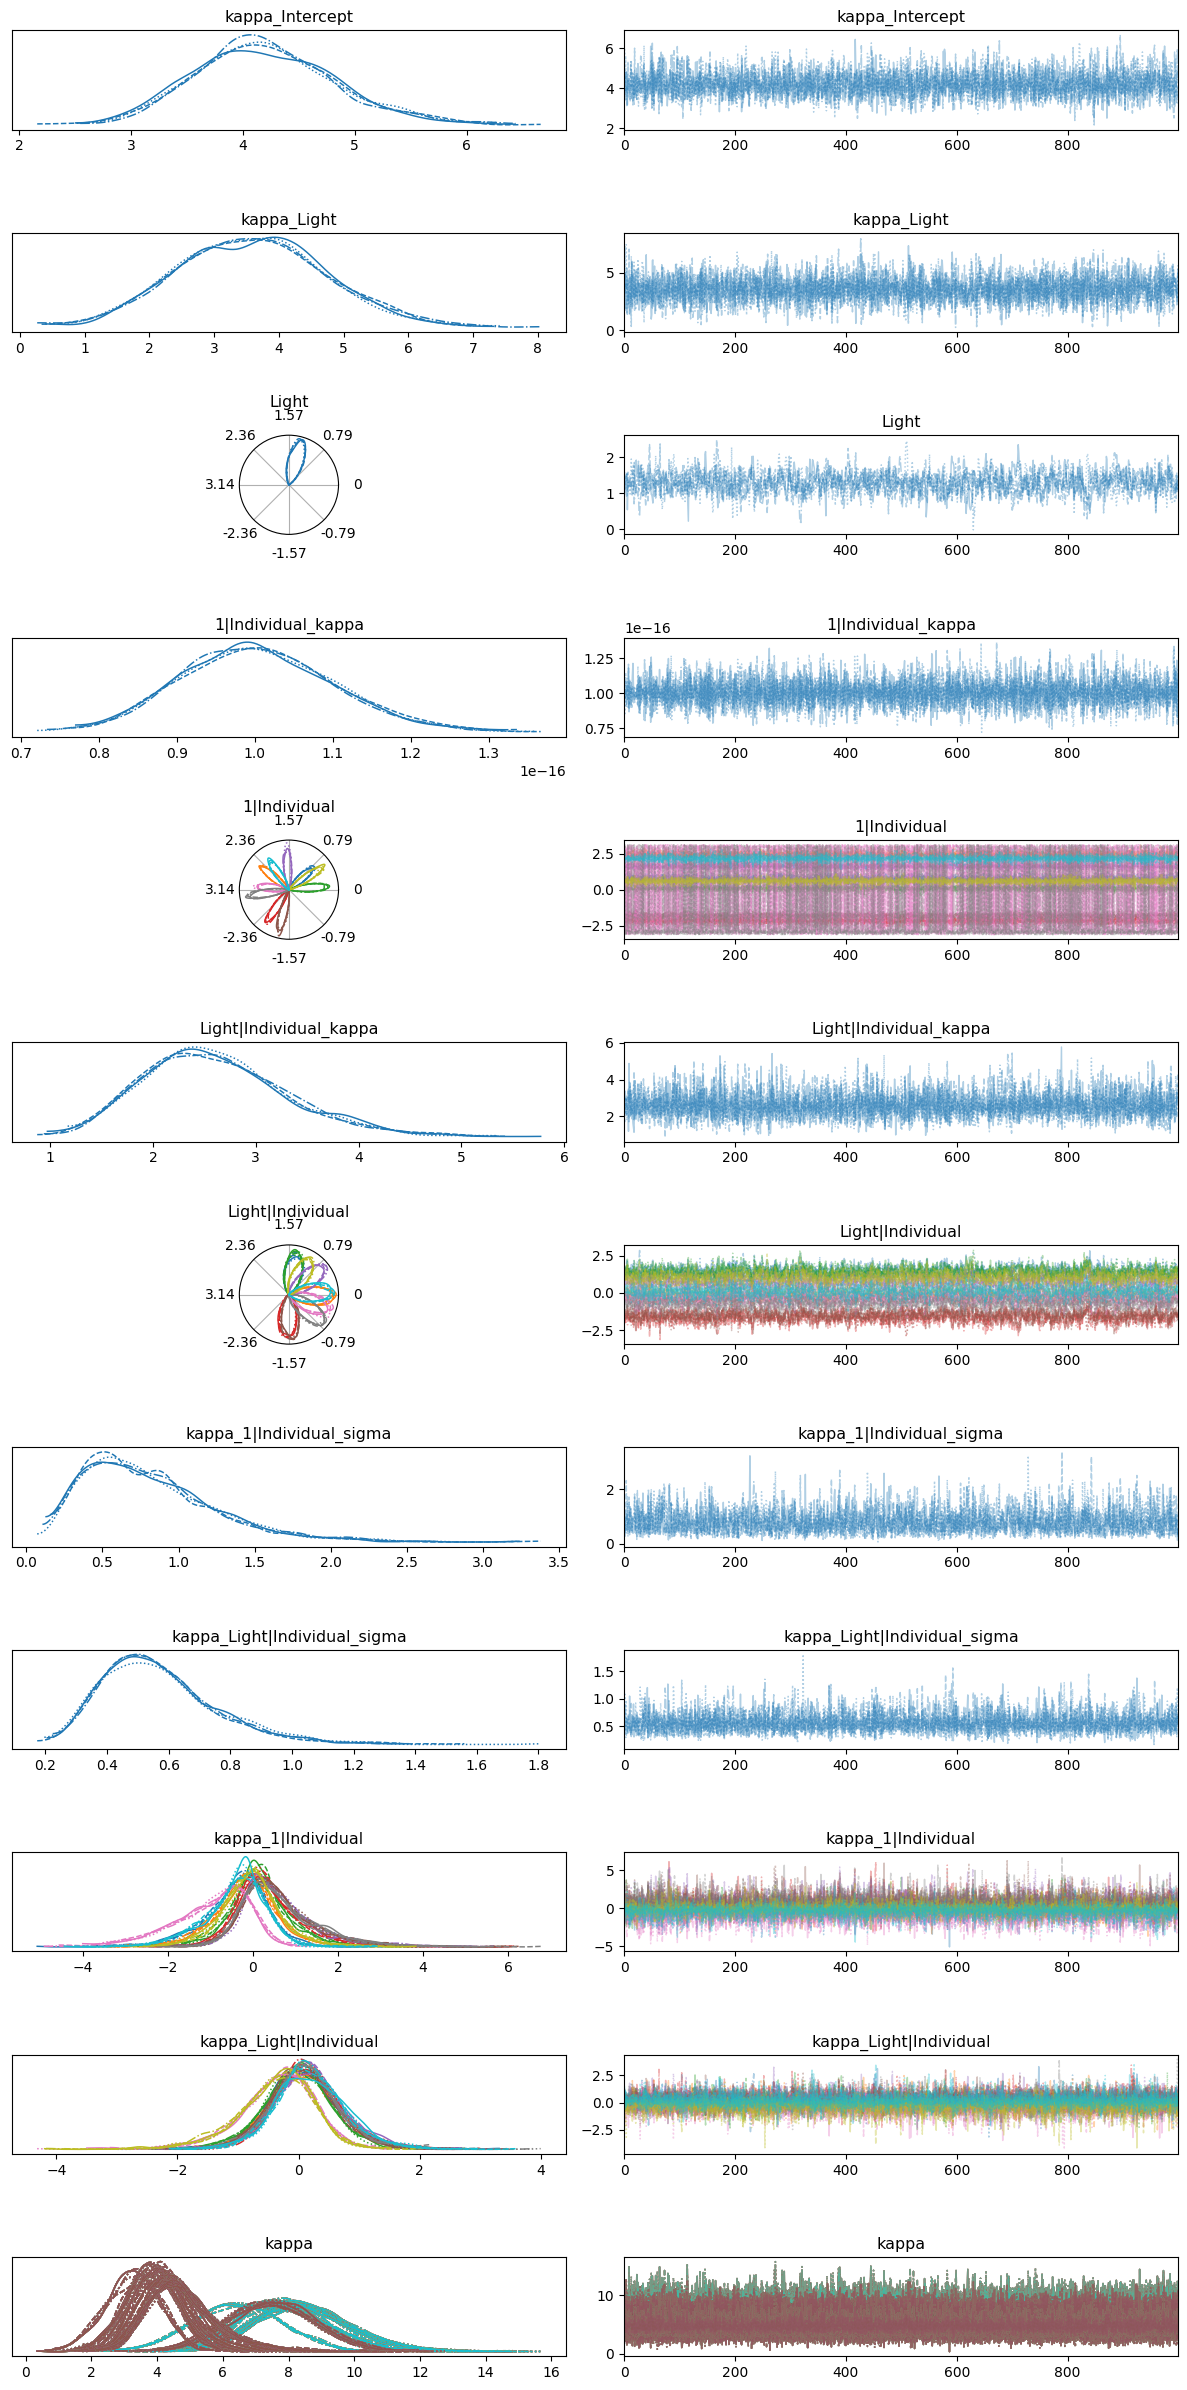

In [17]:
#Specify which parameters are circular
cvars = ["Light", "1|Individual", "Light|Individual"]

az.plot_trace(idata_nomu,
              circ_var_names=cvars,
              ) 
plt.tight_layout()
plt.show()

# Model comparison for hypothesis testing
These three models represent three different hypotheses about the underlying causes of the data. In the **"no mu"** model, we assume that in the control condition individual headings are uncorrelated, only becoming correlated when the light is switched on (treament condition). In the **"no light kappa mu"** model, we assume no effect of the light on the $\kappa_\mu$ parameter governing correlation across individual headings. In the **"treatment"** model, individual heading biases are correlated in both the control and treatment conditions, and the level of correlation may change when the light is switched on.


In [18]:
#Calculate predictive power using LOO cross-validation
import pymc as pm
loo_treat = az.loo(idata_treat) 
loo_nolight_km = az.loo(idata_nolight_km)#Pareto-k warning, should reloo
loo_nomu = az.loo(idata_nomu)

/Users/jamesfoster/Documents/Github/unwrap/.venv/lib/python3.13/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/jamesfoster/Documents/Github/unwrap/.venv/lib/python3.13/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [19]:
#print the results
print('\n----- Treatment effects -----\n')
print(loo_treat)
print('\n----- No light kappa_mu -----\n')
print(loo_nolight_km)
print('\n----- No mu in control -----\n')
print(loo_nomu)
#some warnings in a small proportion of cases, but predictions are generally accurate



----- Treatment effects -----

Computed from 4000 posterior samples and 196 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -133.36    15.43
p_loo       24.46        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      195   99.5%
   (0.70, 1]   (bad)         1    0.5%
   (1, Inf)   (very bad)    0    0.0%


----- No light kappa_mu -----

Computed from 4000 posterior samples and 196 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -210.51    15.70
p_loo       36.61        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      193   98.5%
   (0.70, 1]   (bad)         1    0.5%
   (1, Inf)   (very bad)    2    1.0%


----- No mu in control -----

Computed from 4000 posterior samples and 196 

In [20]:
#compare, ranking models from best to worst
az.compare({
            'Treatment':loo_treat,
            'No light': loo_nolight_km,
            'No mu':loo_nomu,
            }, 
            ic="loo")

rank    elpd_loo      p_loo  elpd_diff    weight         se  \
No mu         0 -132.281744  26.266387   0.000000  0.881330  16.235156   
Treatment     1 -133.355995  24.463839   1.074251  0.112327  15.428149   
No light      2 -210.505888  36.606140  78.224145  0.006343  15.699740   

                dse  warning scale  
No mu      0.000000    False   log  
Treatment  1.581701     True   log  
No light   9.903563     True   log

Since ELPD difference is smaller than the difference in SE, it is unclear whether individual headings are correlated or not in the absence of the light. Both models have considerably larger ELPD (by $\approx 78–79$) than the model with no effect of light on heading bias correlation, much larger than the SE ($\approx 10–12$), so we can conclude that the light does have an effect. Since the $\kappa_\mu$ coefficient was positive for both models, we can assume that the light increased heading bias correlation. 

## Plot treatment model

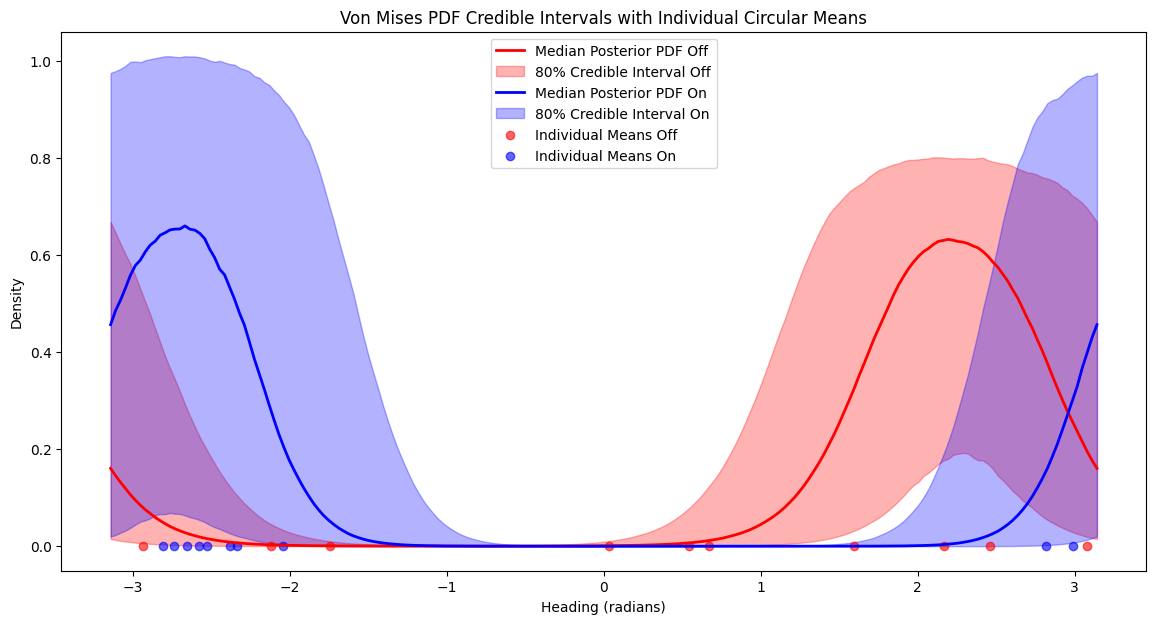

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import vonmises, circmean

# Import shifted_modulo and softplus from unwrap.link.numpy
from unwrap.link.numpy import shifted_modulo, softplus

# --------------------------------------------------
# Extract posterior samples for population-level parameters
# using the Bambi naming scheme with capitalized variable names.
# --------------------------------------------------
# For the μ-model (the main target):
mu_intercept = idata_treat.posterior['Intercept'].values          # fixed intercept for μ
mu_slope     = idata_treat.posterior['Light'].values               # fixed slope for μ

# For the κ-model:
kappa_intercept = idata_treat.posterior['kappa_Intercept'].values    # fixed intercept for κ (linear predictor)
kappa_slope     = idata_treat.posterior['kappa_Light'].values        # fixed slope for κ (linear predictor)

# --------------------------------------------------
# Prepare a grid for plotting the von Mises PDFs
# --------------------------------------------------
theta = np.linspace(-np.pi, np.pi, 200)

fig, ax = plt.subplots(figsize=(14, 7))

# Total number of posterior samples available.
num_samples = mu_intercept.flatten().shape[0]

# Compute population-level parameters for each condition.
mu_pop_off_samples_all = shifted_modulo(mu_intercept.flatten())
mu_pop_on_samples_all  = shifted_modulo((mu_intercept + mu_slope).flatten())
kappa_pop_off_samples_all = softplus(kappa_intercept.flatten())
kappa_pop_on_samples_all  = softplus((kappa_intercept + kappa_slope).flatten())

# --------------------------------------------------
# Compute the von Mises PDF for each posterior sample at each theta.
# The resulting arrays have shape (num_samples, len(theta)).
# --------------------------------------------------
pdf_off = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_off_samples_all[:, None],
    loc=mu_pop_off_samples_all[:, None]
)
pdf_on = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_on_samples_all[:, None],
    loc=mu_pop_on_samples_all[:, None]
)

# For each theta, compute the median and the 95% credible interval.
median_pdf_off = np.median(pdf_off, axis=0)
lower_pdf_off  = np.percentile(pdf_off, 10, axis=0)
upper_pdf_off  = np.percentile(pdf_off, 90, axis=0)

median_pdf_on = np.median(pdf_on, axis=0)
lower_pdf_on  = np.percentile(pdf_on, 10, axis=0)
upper_pdf_on  = np.percentile(pdf_on, 90, axis=0)

# --------------------------------------------------
# Plot the median PDFs and fill between the 95% credible intervals.
# --------------------------------------------------
ax.plot(theta, median_pdf_off, color='red', lw=2, label='Median Posterior PDF Off')
ax.fill_between(theta, lower_pdf_off, upper_pdf_off, color='red', alpha=0.3,
                label='80% Credible Interval Off')

ax.plot(theta, median_pdf_on, color='blue', lw=2, label='Median Posterior PDF On')
ax.fill_between(theta, lower_pdf_on, upper_pdf_on, color='blue', alpha=0.3,
                label='80% Credible Interval On')

# --------------------------------------------------
# Plot the circular means for each individual (individual-level summaries)
# --------------------------------------------------
for i, individual in enumerate(df['Individual'].unique()):
    individual_data = df[df['Individual'] == individual]
    
    # Get headings for Light Off (Light == 0) and Light On (Light == 1)
    headings_off = individual_data.loc[individual_data['Light'] == 0, 'HeadingRadians'].dropna()
    headings_on  = individual_data.loc[individual_data['Light'] == 1, 'HeadingRadians'].dropna()
    
    # Compute circular means for this individual and wrap into [-π, π] using shifted_modulo.
    individual_circmean_off = shifted_modulo(circmean(headings_off))
    individual_circmean_on  = shifted_modulo(circmean(headings_on))
    
    # Plot individual circular means.
    ax.scatter(individual_circmean_off, 0, color='red', alpha=0.6,
               label='Individual Means Off' if i == 0 else "")
    ax.scatter(individual_circmean_on, 0, color='blue', alpha=0.6,
               label='Individual Means On' if i == 0 else "")

ax.set_title('Von Mises PDF Credible Intervals with Individual Circular Means')
ax.set_xlabel('Heading (radians)')
ax.set_ylabel('Density')
ax.legend()
plt.show()


# Inspect the change in $\kappa_\mu$

## Extract individual $\mu$ estimates and calculate mean $\kappa_\mu$

In [22]:
#Calculate estimate of mu for each individual and kappa on average
import numpy as np
from scipy.stats import vonmises, directional_stats
from unwrap.bessel import inverse_bessel_ratio
import arviz as az

# --- 1.1. Extract Fixed Effects (Common-level) for mu ---
mu_intercept_fixed = idata_treat.posterior["Intercept"].values  # Note: No 'mu_' prefix if it's the default component
mu_light_fixed = idata_treat.posterior["Light"].values

# --- 1.2. Extract Random Effects (Group-specific) for mu ---
mu_intercept_random = idata_treat.posterior["1|Individual"].values
mu_light_random = idata_treat.posterior["Light|Individual"].values

# --- 1.3. Get the list of individual IDs ---
# individual_ids = idata_treat.posterior.coords["Individual"].values
# n_individuals = len(individual_ids)
individual_ids = df['Individual'].unique()
n_individuals = len(individual_ids)

# Sum the fixed and random effects for each draw and individual
# mu_intercept_draws = mu_intercept_fixed.values[..., np.newaxis] + mu_intercept_random.values
mu_intercept_draws = shifted_modulo(mu_intercept_fixed[..., np.newaxis] + mu_intercept_random)

# Calculate the mean posterior direction (often the circular mean or just the arithmetic mean of the posterior)
# We will use the arithmetic mean of the draws as a point estimate for simplicity here
mu_intercept_individual_estimates = shifted_modulo(circmean(mu_intercept_draws, axis=(0, 1)))

#for the light on condition
mu_light_draws = shifted_modulo(
    mu_intercept_fixed[..., np.newaxis] + mu_light_fixed[..., np.newaxis] +
    mu_intercept_random + mu_light_random
)

# Calculate the mean posterior direction (point estimate)
mu_light_individual_estimates = shifted_modulo(circmean(mu_light_draws, axis=(0, 1)))

# Fit the von Mises distribution to the set of individual mu estimates
# fscale=1 fixes the scale parameter to 1
kappa_mu_intercept_fit, mu_mu_intercept_fit, scale_fit = vonmises.fit(
    mu_intercept_individual_estimates, fscale=1
)
#N.B. an alternative method would be:
# kappa_mu_intercept_fit = inverse_bessel_ratio(directional_stats(mu_intercept_individual_estimates).mean_resultant_length)

print(f"\n--- Kappa_mu from the Distribution of Individual Mu (Intercept) ---")
print(f"The Kappa_mu (concentration) of the individual mu estimates: {kappa_mu_intercept_fit:.4f}")
# The estimated mu_mu_intercept_fit is the overall mean of the individual means.

# Fit the von Mises distribution to the set of individual mu estimates
kappa_mu_light_fit, mu_mu_light_fit, scale_fit = vonmises.fit(
    mu_light_individual_estimates, fscale=1
)

print(f"\n--- Kappa_mu from the Distribution of Individual Mu (Light) ---")
print(f"The Kappa_mu (concentration) of the individual mu estimates: {kappa_mu_light_fit:.4f}")


--- Kappa_mu from the Distribution of Individual Mu (Intercept) ---
The Kappa_mu (concentration) of the individual mu estimates: 0.5810

--- Kappa_mu from the Distribution of Individual Mu (Light) ---
The Kappa_mu (concentration) of the individual mu estimates: 5.7006


## Extract $\kappa_\mu$ estimates for each draw

In [ ]:
#calculate for each draw
import numpy as np
from scipy.stats import vonmises
import arviz as az

# --- 2.2. Determine Iteration Count and Individual Count ---
n_chain, n_draws, n_individuals = mu_intercept_random.shape
total_draws = n_chain * n_draws

# Initialize an array to store the second-level kappa for each draw
kappamu_intercept_posterior = np.empty(total_draws)
kappamu_light_posterior = np.empty(total_draws)
kappamu_delta_posterior = np.empty(total_draws)

# --- 2.3. Reshape all arrays for easier iteration (Combine chains and draws) ---
# Shape is now (total_draws, n_individuals)
mu_i_random_flat = mu_intercept_random.reshape(total_draws, n_individuals)
mu_L_random_flat = mu_light_random.reshape(total_draws, n_individuals)
mu_I_fixed_flat = mu_intercept_fixed.reshape(total_draws, 1)
mu_L_fixed_flat = mu_light_fixed.reshape(total_draws, 1)


# --- 2.4. Loop through every draw and fit the von Mises distribution ---
print(f"Calculating second-level kappamu for {total_draws} draws...")

for i in range(total_draws):
    
    # 1. Calculate the individual-level mu for the current draw (Light condition)
    # The sum: fixed_I + fixed_L + random_I + random_L
    mu_intercept_individual_draw = (
        mu_I_fixed_flat[i] +
        mu_i_random_flat[i] 
    )
    mu_light_individual_draw = (
        mu_I_fixed_flat[i] + mu_L_fixed_flat[i] +
        mu_i_random_flat[i] + mu_L_random_flat[i]
    )
    
    # 2. Wrap the angles to the preferred [-pi, pi) range
    mu_intercept_wrapped = shifted_modulo(mu_intercept_individual_draw)
    mu_light_wrapped = shifted_modulo(mu_light_individual_draw)
    
    # 3. Fit the von Mises distribution to this set of wrapped individual means
    # fscale=1 fixes the scale
    try:
        kappamu_intercept_fit, _, _ = vonmises.fit(mu_intercept_wrapped, fscale=1)
        #equivalently, but using mean vector length rather than MLE fit
        # kappamu_intercept_fit = inverse_bessel_ratio(directional_stats([mu_intercept_wrapped]).mean_resultant_length) #some potential for bias (rho == 1.0)
        kappamu_intercept_posterior[i] = kappamu_intercept_fit
    except RuntimeError:
        # Handle cases where the MLE optimizer fails (e.g., if all mu's are identical)
        # Assigning a high kappa value, or skipping the draw might be necessary.
        # Here we assign a NaN, which will be filtered later.
        # kappamu_light_posterior[i] = np.nan 
        kappamu_light_posterior[i] = 100#high enough 
    try:
        kappamu_light_fit, _, _ = vonmises.fit(mu_light_wrapped, fscale=1)
        # kappamu_light_fit = inverse_bessel_ratio(directional_stats([mu_light_wrapped]).mean_resultant_length)
        kappamu_light_posterior[i] = kappamu_light_fit
    except RuntimeError:
        # Handle cases where the MLE optimizer fails (e.g., if all mu's are identical)
        # Assigning a high kappa value, or skipping the draw might be necessary.
        # Here we assign a NaN, which will be filtered later.
        # kappamu_light_posterior[i] = np.nan 
        kappamu_light_posterior[i] = 100#high enough 

    kappamu_delta_posterior[i] = kappamu_light_posterior[i] -kappamu_intercept_posterior[i] #change in kappa_mu


# --- 2.5. Summarize the Posterior Distribution of second-level kappa ---
# Filter out any NaNs if the optimizer failed on certain draws
kappamu_intercept_posterior = kappamu_intercept_posterior[~np.isnan(kappamu_intercept_posterior)]
kappamu_light_posterior = kappamu_light_posterior[~np.isnan(kappamu_light_posterior)]

# Convert the array to an ArviZ InferenceData object for easy summary
# We need to reshape it back to (n_chain, n_draws) for ArviZ, though it's flat now.
# For simplicity, we'll use az.summary on the flat array directly.
kappamu_posterior_idata = {"kappa_mu_intercept": kappamu_intercept_posterior,
                            "kappa_mu_light": kappamu_light_posterior,
                            "kappa_mu_delta": kappamu_delta_posterior,
                            }

print("\n--- Summary of Kappa_mu (Light Condition) ---")
print("This represents the posterior distribution of the concentration of individual mu's.")
print(az.summary(kappamu_posterior_idata, hdi_prob=0.95))

Calculating second-level kappamu for 4000 draws...


arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)



--- Summary of Kappa_mu (Light Condition) ---
This represents the posterior distribution of the concentration of individual mu's.
                      mean   sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
kappa_mu_intercept  500.25  0.0    500.25     500.25        0.0      NaN   
kappa_mu_light      500.25  0.0    500.25     500.25        0.0      NaN   
kappa_mu_delta        0.00  0.0      0.00       0.00        0.0      NaN   

                    ess_bulk  ess_tail  r_hat  
kappa_mu_intercept    4000.0    4000.0    NaN  
kappa_mu_light        4000.0    4000.0    NaN  
kappa_mu_delta        4000.0    4000.0    NaN  


/Users/jamesfoster/Documents/Github/unwrap/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


We can see here that for nearly all draws the difference in (post-hoc estimated) $\kappa_\mu$ between the two conditions is positive and large. Calculating $\kappa_\mu$ for the lights off (intercept) condition we get a lower value than $\kappa_\mu$ estimated from the model (`softplus('1|Individual_kappa')`), but it is consistent with the distribution of individual heading biases (`1|Individual`) estimated using those values of $\kappa_\mu$. In a model written using `pymc` directly, we could reformulate the model to estimate both `kappa_mu_intercept` and `kappa_mu_delta` explicitly.

## Plot summary

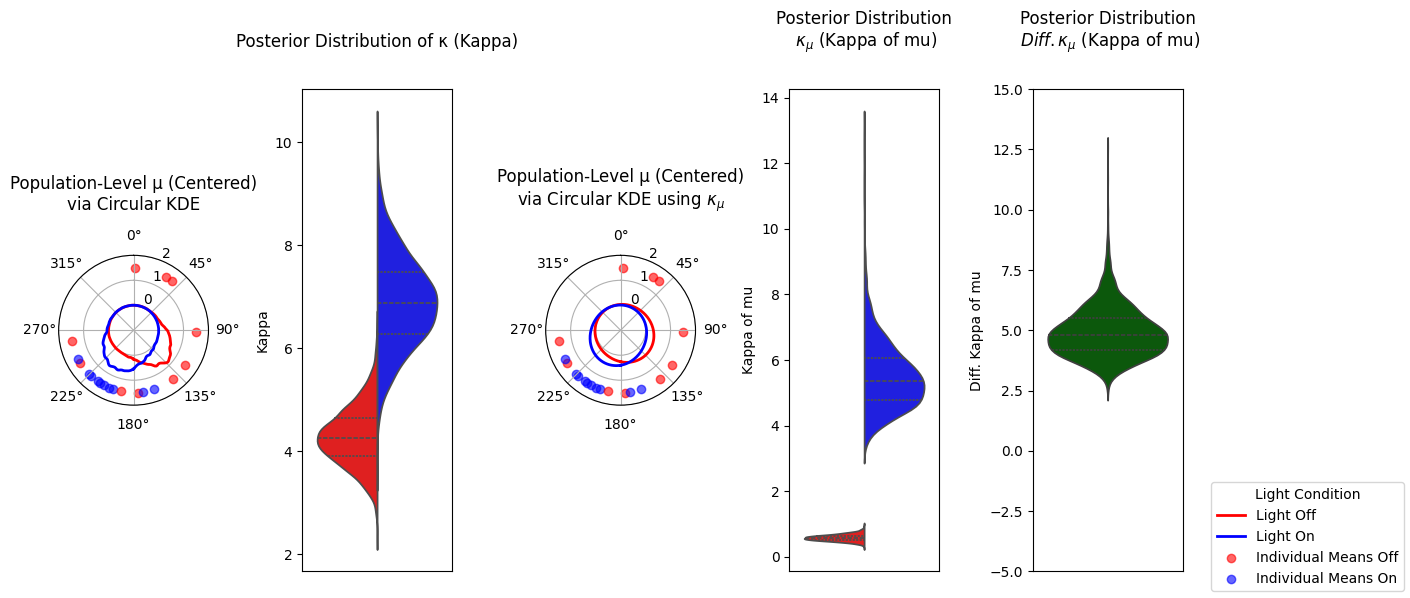

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import circmean, vonmises
from unwrap.link.numpy import shifted_modulo

# --------------------------------------------------
# Extract posterior samples for population-level parameters
# using the Bambi naming scheme with capitalized variable names.
# --------------------------------------------------
# For the μ-model (the main target):
mu_intercept = idata_treat.posterior['Intercept'].values          # fixed intercept for μ
mu_slope     = idata_treat.posterior['Light'].values               # fixed slope for μ

# For the κ-model:
kappa_intercept = idata_treat.posterior['kappa_Intercept'].values    # fixed intercept for κ (linear predictor)
kappa_slope     = idata_treat.posterior['kappa_Light'].values        # fixed slope for κ (linear predictor)

# For the κ_μ-model:
kappamu_intercept = idata_treat.posterior["1|Individual_kappa"].values    # fixed intercept for κ_μ (linear predictor)
kappamu_slope     = idata_treat.posterior["Light|Individual_kappa"].values        # fixed slope for κ_μ (linear predictor)
#N.B. These are the kappamu values for the distibution of headings and distributions of _heading changes_, respectively.
# This is different from the values of kappamu that we calculated for each condition above. kappamu_intercept_posterior & kappamu_light_posterior

# --------------------------------------------------
# Prepare a grid for plotting the von Mises PDFs
# --------------------------------------------------
theta = np.linspace(-np.pi, np.pi, 200)

# fig, ax = plt.subplots(figsize=(14, 7))

# Total number of posterior samples available.
num_samples = mu_intercept.flatten().shape[0]

# Compute population-level parameters for each condition.
mu_pop_off_samples_all = shifted_modulo(mu_intercept.flatten())
mu_pop_on_samples_all  = shifted_modulo((mu_intercept + mu_slope).flatten())
kappa_pop_off_samples_all = softplus(kappa_intercept.flatten())
kappa_pop_on_samples_all  = softplus((kappa_intercept + kappa_slope).flatten())
kappamu_pop_off_samples_all = softplus(kappamu_intercept.flatten())
kappamu_pop_on_samples_all  = softplus(kappamu_slope.flatten())

# --------------------------------------------------
# Assume these arrays are computed from your posterior:
#   mu_pop_off_samples_all, mu_pop_on_samples_all,
#   kappa_pop_off_samples_all, kappa_pop_on_samples_all
# --------------------------------------------------

# ---------------------------
# Process μ (Mu) Samples
# ---------------------------
# Combine all μ samples to compute a common circular center.
mu_all = np.concatenate([mu_pop_off_samples_all, mu_pop_on_samples_all])
common_mu_center = circmean(mu_all, high=np.pi, low=-np.pi)

# Center the μ samples relative to the common center.
mu_off_centered = shifted_modulo(mu_pop_off_samples_all)
mu_on_centered  = shifted_modulo(mu_pop_on_samples_all)

# Set up an angular grid for the circular KDE.
theta = np.linspace(-np.pi, np.pi, 200)

# Choose a bandwidth (concentration) for the von Mises kernel.
kappa_bandwidth = 500  # Adjust as needed

# Compute the circular KDE for each condition.
# For each sample, evaluate the von Mises PDF at each theta, then average over samples.
kde_mu_off = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=kappa_bandwidth,
                 loc=mu_off_centered[:, None]),
    axis=0
)
kde_mu_on = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=kappa_bandwidth,
                 loc=mu_on_centered[:, None]),
    axis=0
)

# Compute the circular KDE for each condition.
# For each sample, evaluate the von Mises PDF at each theta, then average over samples.
kde_kappamu_off = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=np.median(kappamu_pop_off_samples_all),
                 loc=mu_off_centered[:, None]),
    axis=0
)
kde_kappamu_on = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=np.median(kappamu_pop_on_samples_all),
                 loc=mu_on_centered[:, None]),
    axis=0
)


# ---------------------------
# Process κ (Kappa) Samples
# ---------------------------
# For κ (a non-circular variable), no special centering is needed.
kappa_off = kappa_pop_off_samples_all
kappa_on  = kappa_pop_on_samples_all

# Create a DataFrame for the κ split violin plot.
df_kappa = pd.DataFrame({
    "Parameter": ["Kappa"] * (len(kappa_off) + len(kappa_on)),
    "Light": ["Light Off"] * len(kappa_off) + ["Light On"] * len(kappa_on),
    "Value": np.concatenate([kappa_off, kappa_on])
})

# ---------------------------
# Process κ_μ (Kappa of mu) Samples
# ---------------------------
# For κ (a non-circular variable), no special centering is needed.
kappamu_off = kappamu_pop_off_samples_all
kappamu_on  = kappamu_pop_on_samples_all

# Create a DataFrame for the κmu split violin plot.
df_kappamu = pd.DataFrame({
    "Parameter": ["Kappa_mu"] * (len(kappamu_intercept_posterior) + len(kappamu_light_posterior)),
    "Light": ["Light Off"] * len(kappamu_intercept_posterior) + ["Light On"] * len(kappamu_light_posterior),
    "Value": np.concatenate([kappamu_intercept_posterior, kappamu_light_posterior])
})
# Create a DataFrame for the deltaκmu split violin plot.
df_kappamu_delta= pd.DataFrame({
    "Parameter": ["Kappa_mu"] * (len(kappamu_delta_posterior) + len((kappamu_light_posterior - kappamu_off))),
    "Method": ["Post-hoc"] * len(kappamu_delta_posterior) + ["Model"] * len((kappamu_light_posterior - kappamu_off)),
    "Value": np.concatenate([kappamu_delta_posterior, (kappamu_light_posterior - kappamu_off)])
})

# --------------------------------------------------
# Create Subplots: a Polar Plot for μ and a Violin Plot for κ
# --------------------------------------------------
fig = plt.figure(figsize=(14, 6))

# (A) Polar subplot for μ.
ax1 = fig.add_subplot(1, 5, 1, projection='polar')
# Set axes to geographic format (clockwise, 0° at the top)
ax1.set_theta_zero_location('N')#place 0° at the top
ax1.set_theta_direction(-1)#reverse to clockwise
# Add an offset of 1 unit to the density so there's white space in the center.
ax1.plot(theta, kde_mu_off + 1, color='red', lw=2, label='Light Off')
ax1.plot(theta, kde_mu_on + 1, color='blue', lw=2, label='Light On')

    # Scatter-plot data.
# --------------------------------------------------
# Plot the circular means for each individual (individual-level summaries)
# --------------------------------------------------
for i, individual in enumerate(df['Individual'].unique()):
    individual_data = df[df['Individual'] == individual]
    
    # Get headings for Light Off (Light == 0) and Light On (Light == 1)
    headings_off = individual_data.loc[individual_data['Light'] == 0, 'HeadingRadians'].dropna()
    headings_on  = individual_data.loc[individual_data['Light'] == 1, 'HeadingRadians'].dropna()
    
    # Compute circular means for this individual and wrap into [-π, π] using shifted_modulo.
    individual_circmean_off = shifted_modulo(circmean(headings_off))
    individual_circmean_on  = shifted_modulo(circmean(headings_on))
    
    # Plot individual circular means.
    ax1.scatter(individual_circmean_off, 2.5, color='red', alpha=0.6,
               label='Individual Means Off' if i == 0 else "")
    ax1.scatter(individual_circmean_on, 2.5, color='blue', alpha=0.6,
               label='Individual Means On' if i == 0 else "")
    
ax1.set_title("Population-Level μ (Centered)\nvia Circular KDE", va='bottom', pad=30)
# Adjust radial limits: add 1 (the offset) to the maximum density and a little extra space.
max_density = max(np.max(kde_mu_off), np.max(kde_mu_on))
ax1.set_rlim(0, 1 + max_density * 1.5)
ax1.set_rticks([1, 2, 3], [0, 1, 2])

# (B) Cartesian subplot for κ.
ax2 = fig.add_subplot(1, 5, 2)
sns.violinplot(x="Parameter", y="Value", hue="Light",
               data=df_kappa, split=True, inner="quartile",
               palette={"Light Off": "red", "Light On": "blue"},
               ax=ax2)
ax2.set_title("Posterior Distribution of κ (Kappa)", pad=30)
ax2.set_xlabel("")
ax2.set_ylabel("Kappa")
ax2.set_xticks([])

# (C) Polar subplot for kappa mu.
ax3 = fig.add_subplot(1, 5, 3, projection='polar')
# Set axes to geographic format (clockwise, 0° at the top)
ax3.set_theta_zero_location('N')#place 0° at the top
ax3.set_theta_direction(-1)#reverse to clockwise
# Add an offset of 1 unit to the density so there's white space in the center.
ax3.plot(theta, kde_kappamu_off + 1, color='red', lw=2, label='Light Off')
ax3.plot(theta, kde_kappamu_on + 1, color='blue', lw=2, label='Light On')

    # Scatter-plot data.
# --------------------------------------------------
# Plot the circular means for each individual (individual-level summaries)
# --------------------------------------------------
for i, individual in enumerate(df['Individual'].unique()):
    individual_data = df[df['Individual'] == individual]
    
    # Get headings for Light Off (Light == 0) and Light On (Light == 1)
    headings_off = individual_data.loc[individual_data['Light'] == 0, 'HeadingRadians'].dropna()
    headings_on  = individual_data.loc[individual_data['Light'] == 1, 'HeadingRadians'].dropna()
    
    # Compute circular means for this individual and wrap into [-π, π] using shifted_modulo.
    individual_circmean_off = shifted_modulo(circmean(headings_off))
    individual_circmean_on  = shifted_modulo(circmean(headings_on))
    
    # Plot individual circular means.
    ax3.scatter(individual_circmean_off, 2.5, color='red', alpha=0.6,
               label='Individual Means Off' if i == 0 else "")
    ax3.scatter(individual_circmean_on, 2.5, color='blue', alpha=0.6,
               label='Individual Means On' if i == 0 else "")
    
ax3.set_title("Population-Level μ (Centered)\nvia Circular KDE using $κ_μ$", va='bottom', pad=30)
# Adjust radial limits: add 1 (the offset) to the maximum density and a little extra space.
max_density = max(np.max(kde_kappamu_off), np.max(kde_kappamu_on))
ax3.set_rlim(0, 1 + max_density * 1.5)
ax3.set_rticks([1, 2, 3], [0, 1, 2])


# (D) Cartesian subplot for κ_μ.
ax4 = fig.add_subplot(1, 5, 4)
sns.violinplot(x="Parameter", y="Value", hue="Light",
            data=df_kappamu, split=True, inner="quartile",
            palette={"Light Off": "red", "Light On": "blue"},
            ax=ax4)
ax4.set_title("Posterior Distribution\n $κ_μ$ (Kappa of mu)", pad=30)
ax4.set_xlabel("")
ax4.set_ylabel("Kappa of mu")
ax4.set_xticks([])

# (E) Cartesian subplot for κ_μ.
ax5 = fig.add_subplot(1, 5, 5)
# sns.violinplot(x="Parameter", y="Value", hue="Method",
#             data=df_kappamu_delta, split=False, inner="quartile",
#             palette={"Post-hoc": "darkgreen", "Model": "lightgreen"},  
#             ax=ax5)
sns.violinplot(data=pd.DataFrame(kappamu_delta_posterior),
            split=False, inner="quartile",
            color="darkgreen",  
            ax=ax5)
ax5.set_title("Posterior Distribution\n $Diff. κ_μ$ (Kappa of mu)", pad=30)
ax5.set_xlabel("")
ax5.set_ylabel("Diff. Kappa of mu")
ax5.set_xticks([])
ax5.set_ylim(-5, 15)
# --------------------------------------------------
# Create a Common Legend for All Subplots
# --------------------------------------------------
# Remove individual legends from each subplot.
if ax1.get_legend() is not None:
    ax1.get_legend().remove()
if ax2.get_legend() is not None:
    ax2.get_legend().remove()
if ax3.get_legend() is not None:
    ax3.get_legend().remove()
if ax4.get_legend() is not None:
    ax4.get_legend().remove()
# if ax5.get_legend() is not None:
#     ax5.get_legend().remove()

# Extract legend handles and labels from one of the subplots.
handles, labels = ax1.get_legend_handles_labels()

# Place a common legend for the entire figure.
fig.legend(handles, labels, title="Light Condition", loc="lower right")

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to leave space for the legend.
plt.show()